# Proxy Database Forensics

An important aspect of comparing reconstructions is to trace the origins of their differences. This is not a straightforward process, but progress can be made by comparing the proxy data inputs.

Using `cfr.ProxyDatabase` class, we want to take two different proxy databases and identify their similarities and differences. Notably to see how the contents of these respective proxy records can affect the quality of a paleoclimate reconstruction (such as the ones validated in C03_a).

In previous reproduction attempts, where all other input data were held constant and the only change was the subset of the PAGES2k network used as proxy data, the quality of the reconstructions varied drastically. The purpose of this notebook is to dig into the details and pinpoint the exact records that could be problematic, which can make the difference between a successful and unsuccessful emulation of LMRv2.1. 

In [1]:
import cfr 
import numpy as np
import pandas as pd

octave not found, please see README


## Load in the two proxy databases as cfr.ProxyDatabase objects 

The file format can vary, but in this example we will use `.nc` (netCDF) files that were made in notebooks C01. The file names can be replaced, but this is a generic example with `pdb_1` being cfr's PAGES2k and `pdb_2` being Tardif's LMR pickle PAGES2k

In [2]:
pdb_1 = cfr.ProxyDatabase().load_nc('./prev_data/filtered_ptype_res_cfr_pages2kv2.nc')
pdb_1.refresh()
pdb_2 = cfr.ProxyDatabase().load_nc('./prev_data/lmr_pickle_pages2k.nc')
pdb_2.refresh()

In [3]:
print(f'cfr PAGES2k has {len(pdb_1.records)} records')
print(f'LMR pickle PAGES2k has {len(pdb_2.records)} records')

cfr PAGES2k has 558 records
LMR pickle PAGES2k has 544 records


### Plot the two ProxyDBs

We use `ProxyDatabase.plot()` to get a full picture, but in optionally we can use `ProxyDatabase.plotly()` to obtain an interactive map with metadata information (pid, ptype, lat, lon) as we hover over each point.

(<Figure size 1000x1000 with 2 Axes>,
 {'map': <GeoAxes: title={'center': 'cfr PAGES2k'}>,
  'count': <Axes: xlabel='Year (AD)', ylabel='number of proxies'>})

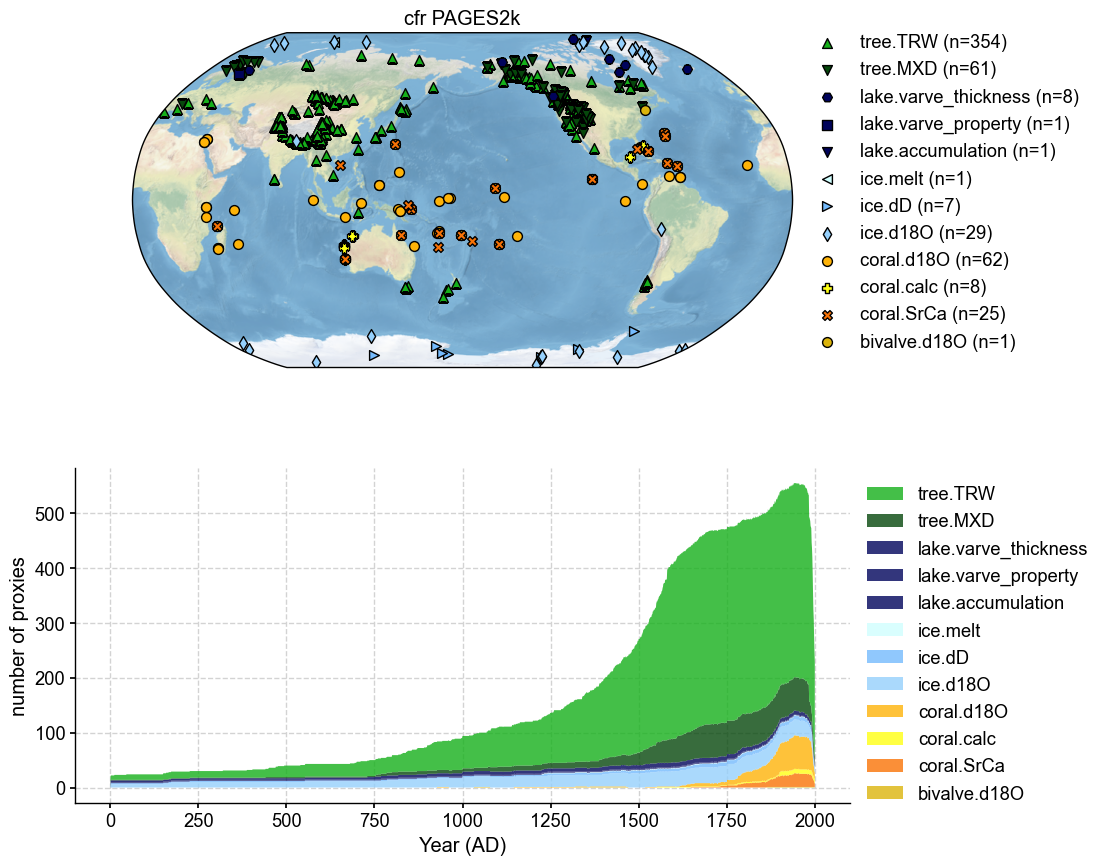

In [4]:
pdb_1.plot(plot_count=True, title= 'cfr PAGES2k')

(<Figure size 1000x1000 with 2 Axes>,
 {'map': <GeoAxes: title={'center': 'LMR pickle PAGES2k'}>,
  'count': <Axes: xlabel='Year (AD)', ylabel='number of proxies'>})

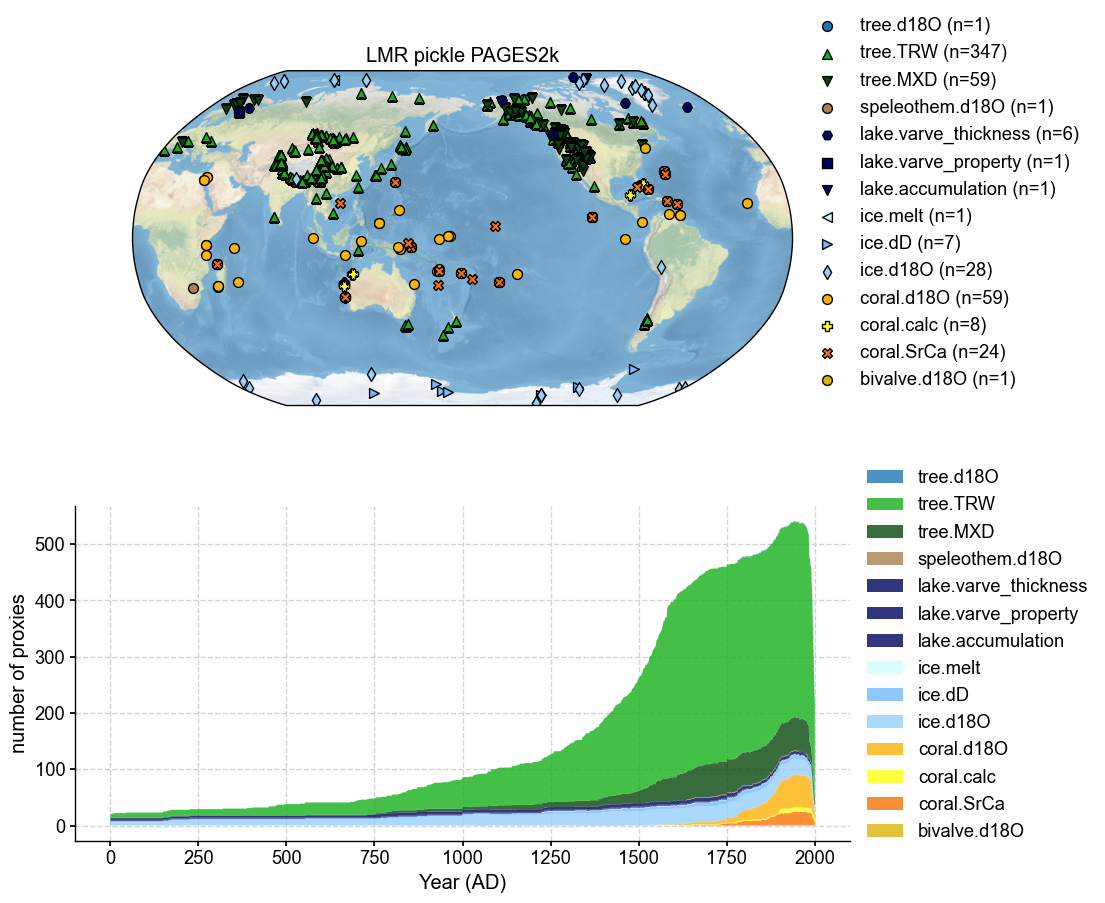

In [5]:
pdb_2.plot(plot_count=True, title = 'LMR pickle PAGES2k')

## Compare PID lists

Here we simply want to see the number of records that are in or not in each respective proxy database so we can point out which ones are making a difference within a reconstruction (if at all).

In [6]:
# Get PID sets
pdb1_pids = set(pdb_1.to_df()['pid'])
pdb2_pids = set(pdb_2.to_df()['pid'])

# Find differences
overlap = pdb1_pids & pdb2_pids # just a set with the record names
missing_in_pdb1 = pdb_2 - pdb_1 # a proxy database
missing_in_pdb2 = pdb_1 - pdb_2 # a proxy database

print(f'Overlapping records: {len(overlap)}')
print(f'Missing from cfr PAGES2k: {len(missing_in_pdb1.records)}') 
print(f'Missing from LMR pickle PAGES2k: {len(missing_in_pdb2.records)}')

>>> Subtracting Ocn_177 failed.
>>> Subtracting Ocn_103 failed.
>>> Subtracting Arc_079 failed.
>>> Subtracting Asi_012 failed.
>>> Subtracting Aus_002 failed.
>>> Subtracting Eur_013 failed.
>>> Subtracting Arc_030 failed.
>>> Subtracting NAm_082 failed.
>>> Subtracting Ocn_175 failed.
>>> Subtracting Ocn_176 failed.
>>> Subtracting Ant_008 failed.
>>> Subtracting Aus_001 failed.
>>> Subtracting NAm_131 failed.
>>> Subtracting Arc_062 failed.
>>> Subtracting Arc_007 failed.
>>> Subtracting Arc_076 failed.
>>> Subtracting Afr_012 failed.
>>> Subtracting Arc_22 failed.
Overlapping records: 542
Missing from cfr PAGES2k: 2
Missing from LMR pickle PAGES2k: 16


## Convert the differences into ProxyDatabase Objects 

using the '-' operator built into _cfr_ means that `missing_in_pdb1` and `missing_in_pdb2` are already proxyDatabase objects, but `overlap` is not. 

In [7]:
def make_pdb_from_df(df, pid_list):
    return cfr.ProxyDatabase().from_df(
        df[df['pid'].isin(pid_list)],
        pid_column='pid', lat_column='lat', lon_column='lon',
        elev_column='elev', time_column='time',
        value_column='value', ptype_column='ptype'
    )

overlap_pdb = make_pdb_from_df(pdb_1.to_df(), overlap)


### Plot the missing ones

Optionally use `plotly` to identify exact records

(<Figure size 1000x1000 with 2 Axes>,
 {'map': <GeoAxes: title={'center': 'Records in Both Databases'}>,
  'count': <Axes: xlabel='Year (AD)', ylabel='number of proxies'>})

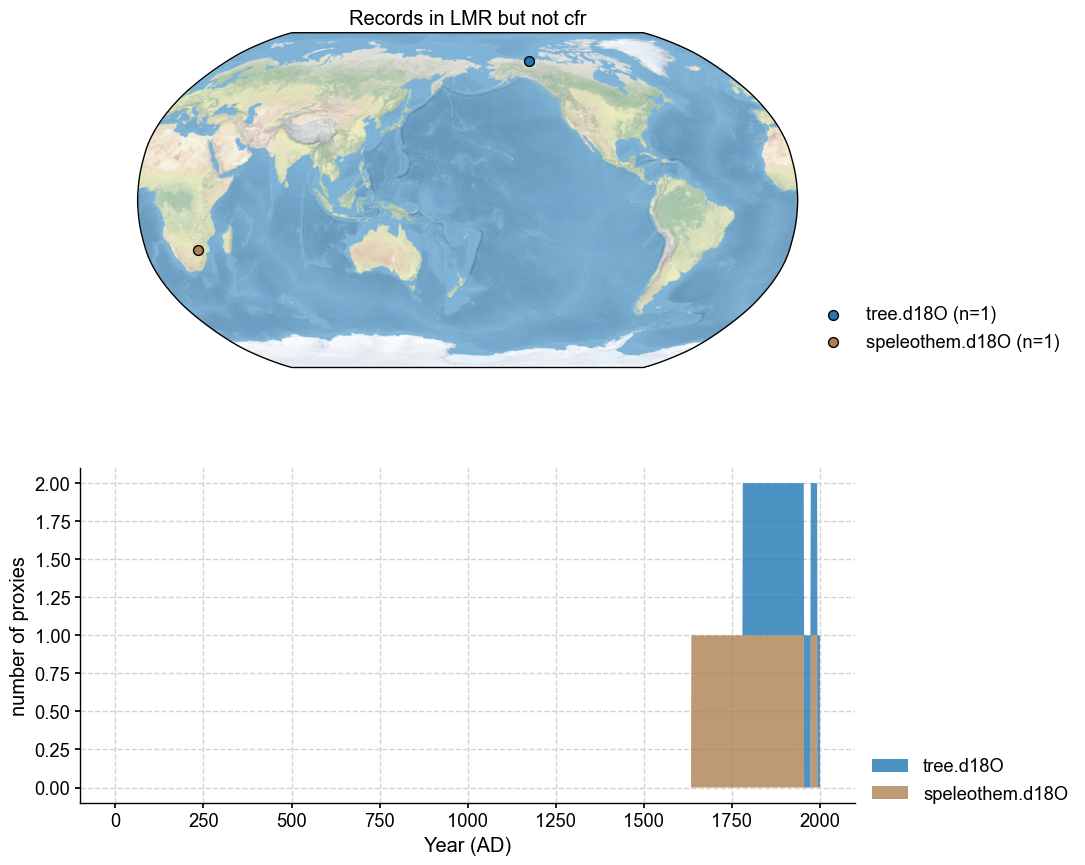

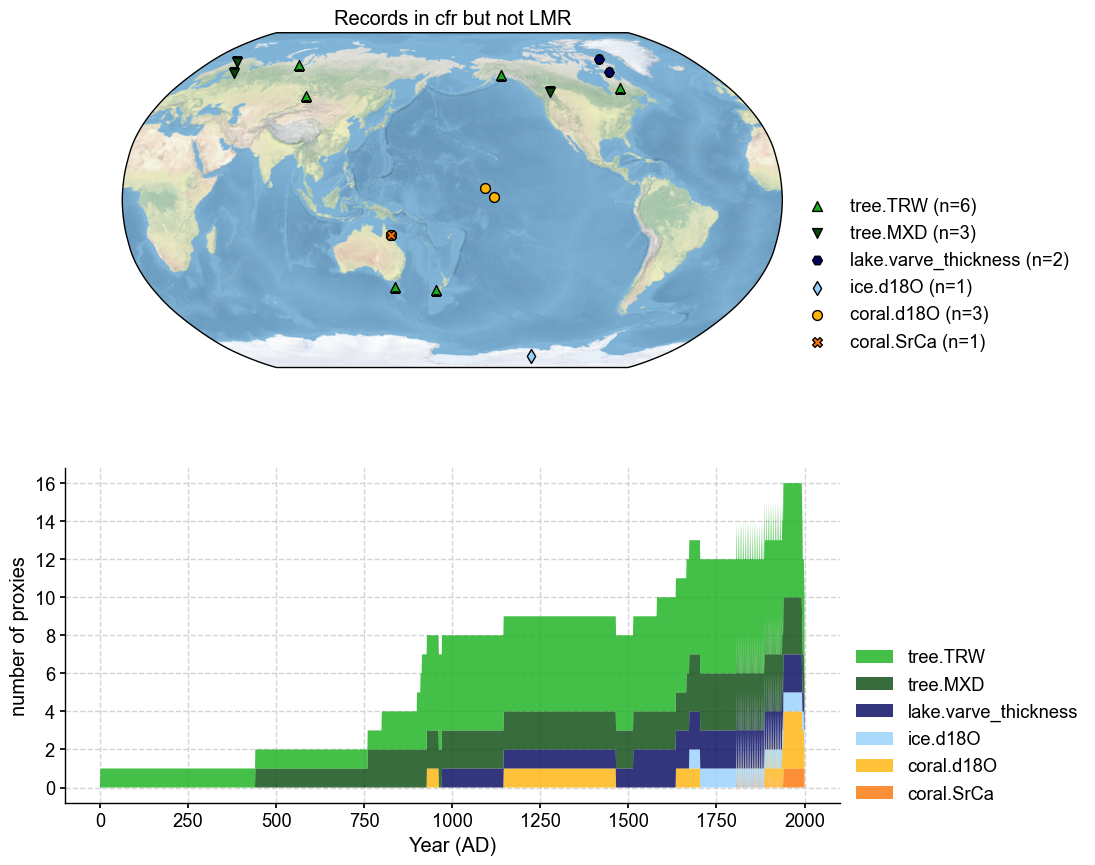

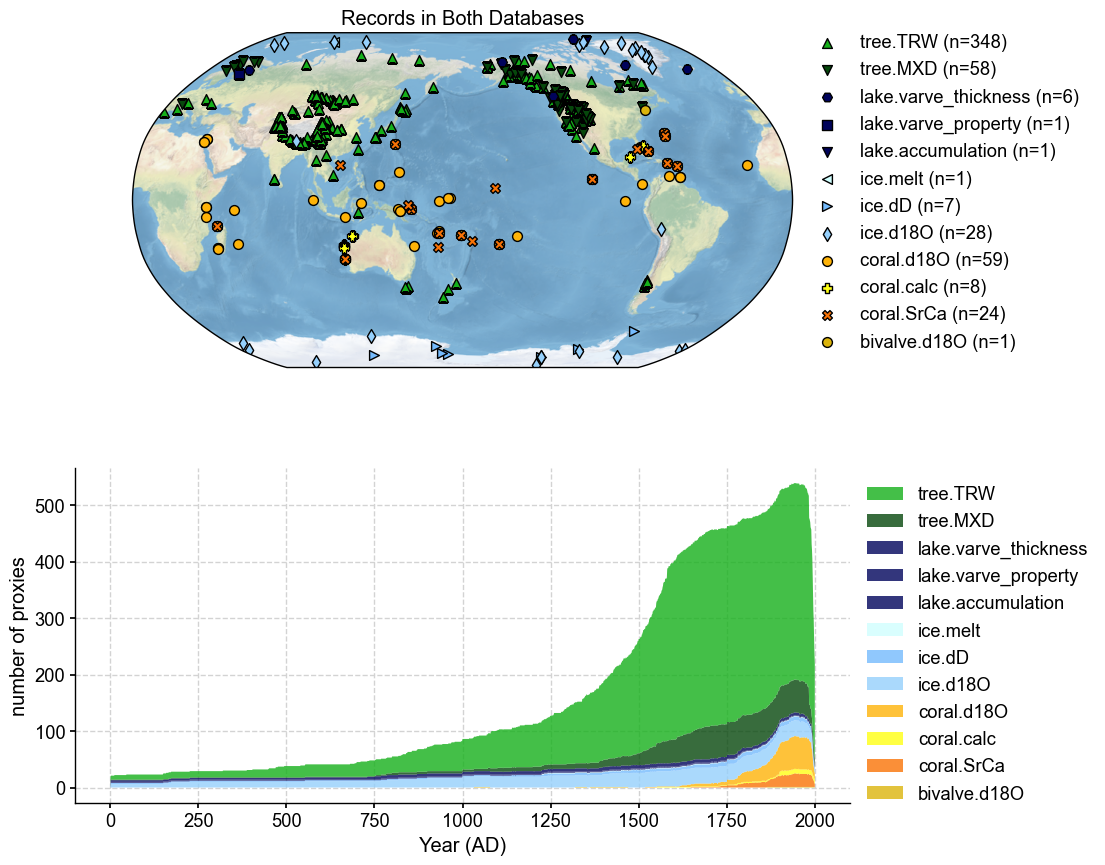

In [8]:
missing_in_pdb1.plot(plot_count=True, title='Records in LMR but not cfr')
missing_in_pdb2.plot(plot_count=True, title='Records in cfr but not LMR')

# Plot overlap
overlap_pdb.plot(plot_count=True, title='Records in Both Databases')

## Plot overlap to see if individual records are the same

This is a quick way to visually check whether matching records across two databases actually contain the same data. One of the first differences you may notice is if the two matching records aren't overlapping correctly. This could mean that the data of one database could have been pre-cleaned or annualized. These differences can show up as mismatches in resolution, spacing, amplitude, or extra noise. Overlapping plots with matching PIDs can help confirm whether something subtle changed during the pre-processing step, which might not show up in the metadata but can still affect the reconstruction.

In [ ]:
import matplotlib.pyplot as plt
import math

def plot_overlap(pdb_1, pdb_2, pid_list=None, ncols=4, figsize=(4, 2.5)):
    """
    Plots matching proxy records from two databases overlaid in subplots.

    Parameters
    ----------
    pdb_1 : cfr.ProxyDatabase
        First proxy database (e.g., original).
    pdb_2 : cfr.ProxyDatabase
        Second proxy database (e.g., reproduced).
    pid_list : list of str, optional
        List of PIDs to plot. If None, uses intersection of both databases.
    ncols : int
        Number of columns in the subplot grid.
    figsize : tuple
        Size of each subplot (width, height).
    """
    if pid_list is None:
        pid_list = list(set(pdb_1.records.keys()) & set(pdb_2.records.keys()))

    n = len(pid_list)
    nrows = math.ceil(n / ncols)

    fig, axs = plt.subplots(nrows, ncols, figsize=(figsize[0]*ncols, figsize[1]*nrows), squeeze=False)

    for idx, pid in enumerate(pid_list):
        row, col = divmod(idx, ncols)
        ax = axs[row][col]

        rec1 = pdb_1[pid]
        rec2 = pdb_2[pid]

        # Sort by time in case
        t1, v1 = zip(*sorted(zip(rec1.time, rec1.value)))
        t2, v2 = zip(*sorted(zip(rec2.time, rec2.value)))

        ax.plot(t1, v1, label='DB1', lw=1, alpha=0.7)
        ax.plot(t2, v2, label='DB2', lw=1, alpha=0.7, linestyle='--')

        ax.set_title(f'{pid} ({rec1.dt})', fontsize=8)
        ax.tick_params(labelsize=6)

    # Remove unused axes
    for i in range(n, nrows * ncols):
        row, col = divmod(i, ncols)
        fig.delaxes(axs[row][col])

    fig.suptitle("Matching Record PIDs: Overlap of cfr vs LMR PAGES2k", fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=0.93)
    plt.show()


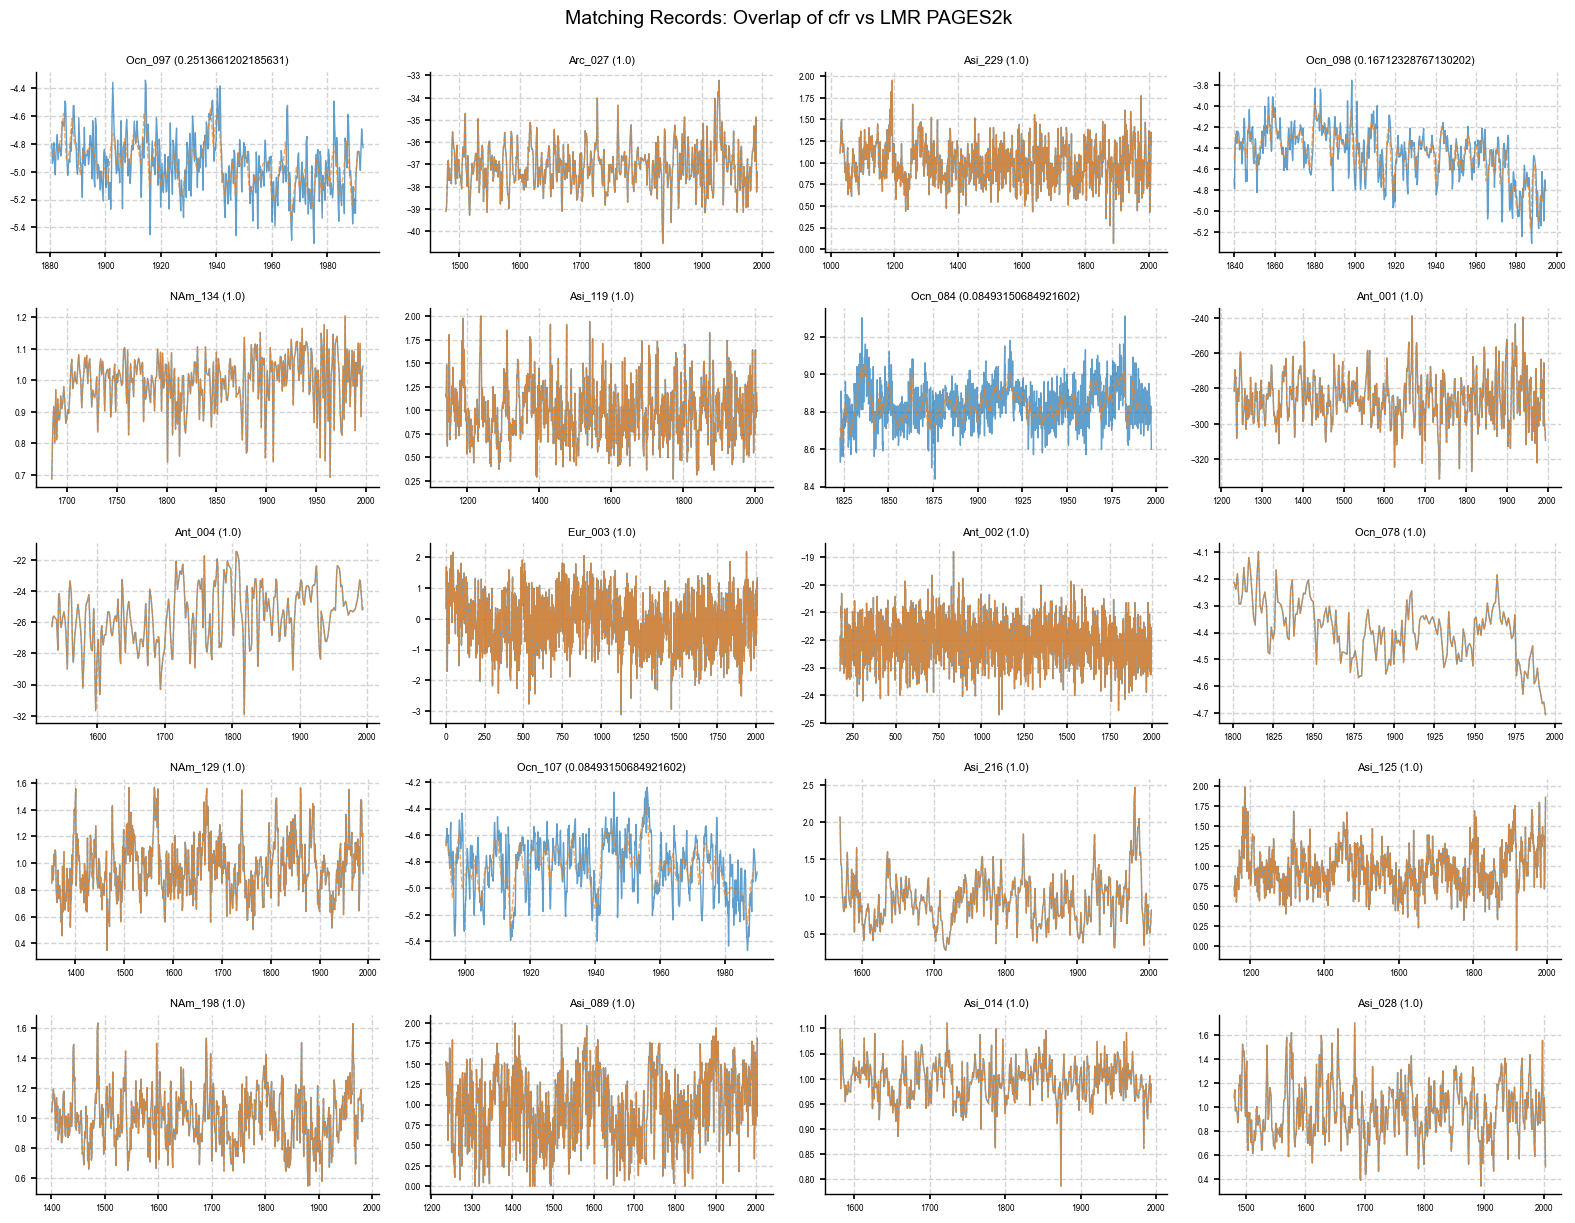

In [10]:
overlap_pids = list(set(pdb_1.records.keys()) & set(pdb_2.records.keys()))
plot_overlap(pdb_1, pdb_2, pid_list=overlap_pids[:20])  # as an example, plotting only the first 20


## Plot start times for each proxydb 

Looking at when proxy records start can help flag differences between databases that might seem minor but actually matter. If one version includes more records starting at early times than another, that can change how much variability, particularly pre-industrial, gets captured in the reconstruction. Doing this step post-filtering is also a good check to see the spread of start dates. This plot is a quick way to spot those kinds of changes, which can be the difference between a good and bad emulation of a reconstruction, in our case, LMRv2.1.

In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

def plot_start_dates(pdb_1, pdb_2, label_1='PDB1', label_2='PDB2'):
    """
    Plots a categorized bar chart of start dates for two proxy databases.

    Parameters
    ----------
    pdb_1, pdb_2 : cfr.ProxyDatabase
        Proxy databases to compare.
    label_1, label_2 : str
        Labels for the two databases in the legend.
    """
    def get_start_dates(pdb):
        return [min(pobj.time) for pobj in pdb.records.values()]

    def bin_dates(dates):
        bins = {'< 0': 0, '0–500': 0, '500–1000': 0, '1000–1500': 0, '1500–2000': 0}
        for d in dates:
            if d < 0:
                bins['< 0'] += 1
            elif d < 500:
                bins['0–500'] += 1
            elif d < 1000:
                bins['500–1000'] += 1
            elif d < 1500:
                bins['1000–1500'] += 1
            else:
                bins['1500–2000'] += 1
        return bins

    bins_1 = bin_dates(get_start_dates(pdb_1))
    bins_2 = bin_dates(get_start_dates(pdb_2))

    categories = list(bins_1.keys())
    x = np.arange(len(categories))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    bar1 = ax.barh(x - width/2, list(bins_1.values()), height=width, label=label_1, color='skyblue')
    bar2 = ax.barh(x + width/2, list(bins_2.values()), height=width, label=label_2, color='salmon')

    ax.set_xlabel('Number of Records')
    ax.set_yticks(x)
    ax.set_yticklabels(categories)
    ax.set_title('Start Dates of Proxy Records')
    ax.invert_yaxis()
    ax.legend()
    ax.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


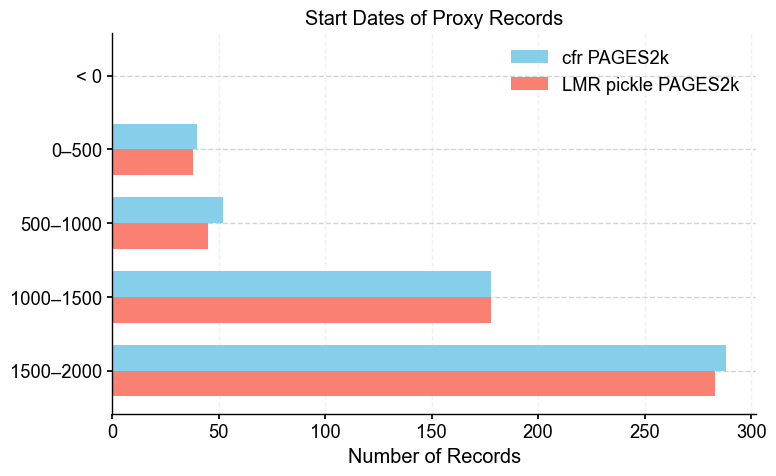

In [ ]:
plot_start_dates(pdb_1, pdb_2, label_1='cfr PAGES2k', label_2='LMR pickle PAGES2k')